In [1]:
# Set up packages for lecture. Don't worry about understanding this code, but
# make sure to run it if you're following along.
import numpy as np
import babypandas as bpd
import pandas as pd
from matplotlib_inline.backend_inline import set_matplotlib_formats
import matplotlib.pyplot as plt
set_matplotlib_formats("svg")
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

from IPython.display import display, IFrame, HTML

def show_permutation_testing_intro():
    src="https://docs.google.com/presentation/d/e/2PACX-1vT3IfZAbqXtscEPu-nTl6lWZcXh6AWfjKsXZpWDNc0UhueXsOYQ7ivShlwbn-PW1EZm7CunTLtq7rmt/embed?start=false&loop=false&delayms=60000"
    width = 960
    height = 635
    display(IFrame(src, width, height))

def show_permutation_testing_summary():
    src = "https://docs.google.com/presentation/d/e/2PACX-1vSovXDonR6EmjrT45h4pY1mwmcKFMWVSdgpbKHC5HNTm9sbG7dojvvCDEQCjuk2dk1oA4gmwMogr8ZL/embed?start=false&loop=false&delayms=3000"
    width = 960
    height = 569
    display(IFrame(src, width, height))

# Lecture 17 – TVD, Permutation Testing

## DSC 10, Fall 2022

### Announcements

- Lab 5 is due **Saturday 11/5 at 11:59pm**.
- Homework 5 is due **Tuesday 11/8 at 11:59pm**.

### Agenda

- Total variation distance.
- Permutation testing.

## Total variation distance

### Recall: jury panels in Alameda County

We have two distributions:

- The ethnic distribution of all eligible panelists in Alameda County – this is a **population** distribution.

- The ethnic distribution of 1453 observed panelists – this is a **sample distribution**.

In [2]:
jury = bpd.DataFrame().assign(
    Ethnicity=['Asian', 'Black', 'Latino', 'White', 'Other'],
    Eligible=[0.15, 0.18, 0.12, 0.54, 0.01],
    Panels=[0.26, 0.08, 0.08, 0.54, 0.04]
)
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


- Last class, we introduced a test statistic that quantifies **how different two categorical distributions are**.

### Total variation distance

The **Total Variation Distance (TVD)** of two categorical distributions is **the sum of the absolute differences of their proportions, all divided by 2**.

In [3]:
def total_variation_distance(dist1, dist2):
    '''Computes the TVD between two categorical distributions, 
       assuming the categories appear in the same order.'''
    return np.abs((dist1 - dist2)).sum() / 2

In [4]:
jury

,Ethnicity,Eligible,Panels
0,Asian,0.15,0.26
1,Black,0.18,0.08
2,Latino,0.12,0.08
3,White,0.54,0.54
4,Other,0.01,0.04


In [5]:
# Calculate the TVD between the distribution of ethnicities in the eligible population
# and the distribution of ethnicities in the observed panelists

total_variation_distance(jury.get('Eligible'), jury.get('Panels'))

0.14

One way of interpreting it is as the **total overrepresentation** across all categories.

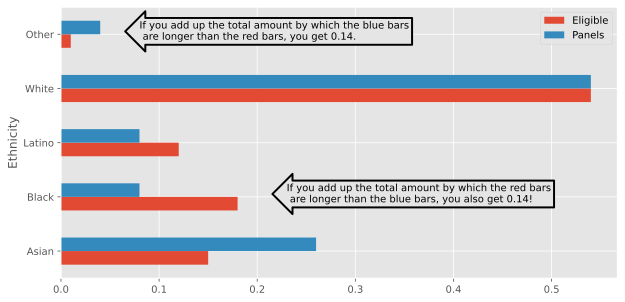

In [6]:
jury.plot(kind='barh', x='Ethnicity', figsize=(10, 5))
plt.annotate('If you add up the total amount by which the blue bars\n are longer than the red bars, you get 0.14.', (0.08, 3.9), bbox=dict(boxstyle="larrow,pad=0.3", fc="#e5e5e5", ec="black", lw=2));
plt.annotate('If you add up the total amount by which the red bars\n are longer than the blue bars, you also get 0.14!', (0.23, 0.9), bbox=dict(boxstyle="larrow,pad=0.3", fc="#e5e5e5", ec="black", lw=2));

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com) 

What is the TVD between the distributions of class standing in DSC 10 and DSC 40A?

| **Class Standing** | **DSC 10** | **DSC 40A** |
| --- | --- | --- |
| Freshman | 0.45 | 0.15 |
| Sophomore | 0.35 | 0.35 |
| Junior | 0.15 | 0.35 |
| Senior+ | 0.05 | 0.15 |

- A. 0.2
- B. 0.3
- C. 0.5
- D. 0.6
- E. None of the above

### Simulate drawing jury panels
- Model: Panels are drawn at random from the eligible population.

- Statistic: TVD between the panel's ethnic distribution and the eligible population's ethnic distribution.

- Repeat many times to generate many TVDs, and see where the TVD of the observed panelists lies.

_Note_: `np.random.multinomial` creates samples drawn with replacement, even though real jury panels would be drawn without replacement. However, when the sample size (1453) is small relative to the population (number of people in Alameda County), the resulting distributions will be roughly the same whether we sample with or without replacement.

### The experiment

In [27]:
eligible = jury.get('Eligible')
sample_distribution = np.random.multinomial(1453, eligible) / 1453 
sample_distribution

array([0.13, 0.18, 0.12, 0.57, 0.01])

In [28]:
total_variation_distance(sample_distribution, eligible)

0.02810736407432896

We need to repeat the process of drawing a sample and computing the total variation distance many, many times.

### Repeating the experiment

In [29]:
tvds = np.array([])
repetitions = 10000
for i in np.arange(repetitions):
    sample_distribution = np.random.multinomial(1453, eligible) / 1453
    new_tvd = total_variation_distance(sample_distribution, eligible)
    tvds = np.append(tvds, new_tvd)

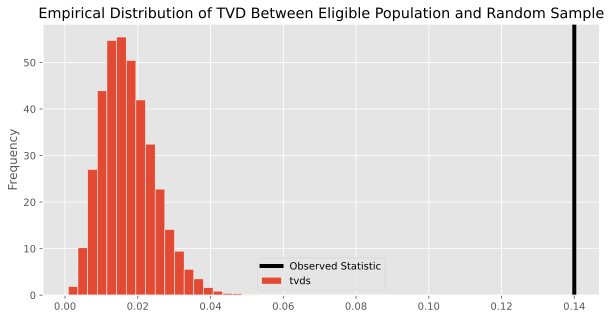

In [30]:
observed_tvd = total_variation_distance(jury.get('Panels'), eligible)

bpd.DataFrame().assign(tvds=tvds).plot(kind='hist', density=True, bins=20, ec='w', figsize=(10, 5),
                                      title='Empirical Distribution of TVD Between Eligible Population and Random Sample')
plt.axvline(observed_tvd, color='black', linewidth=4, label='Observed Statistic')
plt.legend();

### Calculating the p-value

In [31]:
np.count_nonzero(tvds >= observed_tvd) / repetitions

0.0

- Random samples from the eligible population are typically **much more similar** to the eligible population than our observed data. 
- We see this in the empirical distribution, which consists of **small TVDs** (much smaller than our observed TVD).

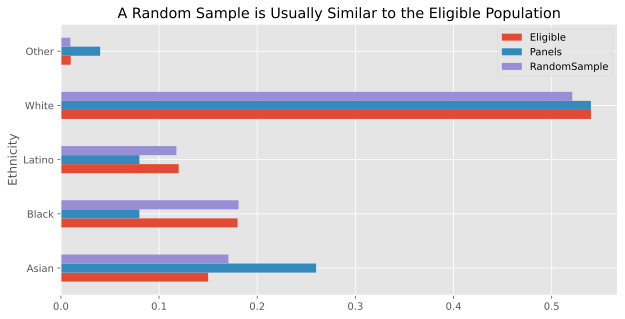

In [32]:
jury.assign(RandomSample=sample_distribution).plot(kind='barh', x='Ethnicity', figsize=(10, 5),
                                                   title="A Random Sample is Usually Similar to the Eligible Population");

### Are the jury panels representative?
- Likely not! The ethnic distributions of our random samples are not like the ethnic distribution of our observed panelists.

- This doesn't say *why* the distributions are different!
    - Juries are drawn from voter registration lists and DMV records. Certain populations are less likely to be registered to vote or have a driver's license due to historical biases.
    - The county rarely enacts penalties for those who don't appear for jury duty; certain populations are less likely to be able to miss work to appear for jury duty.
    - [See the report](https://www.aclunc.org/sites/default/files/racial_and_ethnic_disparities_in_alameda_county_jury_pools.pdf) for more reasons.

## Motivating A/B testing

### Reflection

So far, we've used hypothesis tests to answer questions of the form:

> I have a population distribution, and I have **one sample**. Does this sample look like it was drawn from the population?

- We flip a coin 400 times. Are the flips consistent with the coin being fair?

- Did the jury panel in the Swain case look like a random sample from the eligible population?

- Are the midterm scores for Section C a random sample from the class's scores?

### Looking forward

Consider the following form of question:

> I have **two samples**, but no information about any population distributions. Do these samples look like they were drawn from the same population?

We can't use hypothesis testing to answer such questions yet, because all of our hypothesis tests have relied on **knowing the population distribution**. But what if you don't know the population distribution?

- Are the distributions of weight for babies 👶 born to smoking mothers vs. non-smoking mothers different?

- Are the distributions of pressure drops for footballs 🏈 from two different teams different?

These questions are answered through **A/B testing**. Permutation testing is **one type of** A/B testing.

### 2008 Obama Campaign

<center><img src='data/obama.png' width=600></center>

- In 2008, the Obama campaign tested several different versions of a pop-up box on their website. Each visitor to the site would view a random version of the site, with different buttons and images.

- For each version, they recorded the number of people who signed up to be a donor.

- Read more at [this blog post](https://blog.optimizely.com/2010/11/29/how-obama-raised-60-million-by-running-a-simple-experiment/).

### Button choices

- Here are the four different buttons they used.

<center><img src='data/buttons.png' width=400>

- Intuitively, which one do you think would lead to the most signups?

### The winner

<center><img src='data/winner.png' width=600>

It is estimated that this combination of image and button brought in an **additional 60 million dollars** in donations versus the original version of the site.

## Example: Smoking and birth weight 👶

### Smoking and birth weight

- **Question:** Is there a significant difference in the weights of babies born to mothers who smoked vs. babies born to mothers who didn't smoke?

- To approach this question, we'll look at data from an **observational study**.
    - Each row corresponds to a baby.
    - There are two groups of babies: those whose mothers smoked ("smokers' babies"), and those whose mothers didn't smoke ("non-smokers' babies").

In [33]:
babies = bpd.read_csv('data/baby.csv').get(['Maternal Smoker', 'Birth Weight'])
babies

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
...,...,...
1171,True,130
1172,False,125
1173,False,117


Note: The `'Birth Weight'` column is measured in ounces; 100 ounces = 6.25 pounds.

### Visualizing the distribution of each group

In [34]:
smokers = babies[babies.get('Maternal Smoker')]
non_smokers = babies[babies.get('Maternal Smoker') == False]

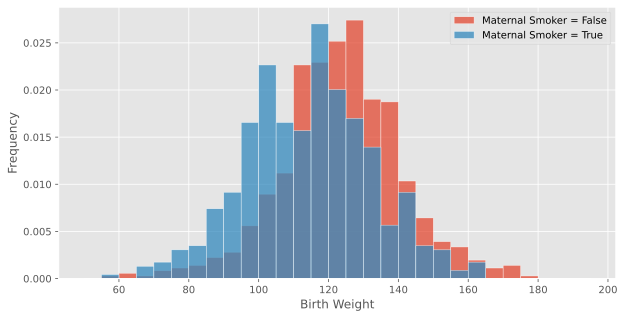

In [35]:
fig, ax = plt.subplots()
baby_bins = np.arange(50, 200, 5)
non_smokers.plot(kind='hist', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w', figsize=(10, 5))
smokers.plot(kind='hist', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w')
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight');

What do you notice? 👀

### The question

- It appears that, **in our sample**, smokers' babies typically have lower birth weights than non-smokers' babies.

- Does the difference we see reflect a real difference in the population?

- Or is this pattern just due to random chance?

- Let's run a hypothesis test!

### Setting up a hypothesis test

- **Null Hypothesis**: In the population, birth weights of smokers' babies and non-smokers' babies have the same distribution, and the observed differences in our samples are due to random chance.

- **Alternative Hypothesis**: In the population, smokers' babies have lower birth weights than non-smokers' babies, on average. The observed differences in our samples cannot be explained by random chance alone.

- Now that we have our hypotheses, we need to devise a test statistic that we can simulate under the null hypothesis.

### Discussion Question

We recently introduced the total variation distance (TVD) as a test statistic. Why **can't** we use the TVD as our test statistic in this hypothesis test?

### Test statistic: the difference in group means

The test statistic we'll use is the difference in group means:

$$\substack{\text{mean birth weight of} \\ \text{non-smokers' babies}} \hspace{0.5in} - \hspace{0.5in} \substack{\text{mean birth weight of} \\ \text{smokers' babies}}$$

Note that **large values of this test statistic favor the alternative hypothesis**.

Let's compute the observed statistic:

In [36]:
means_table = babies.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.09
True,113.82


In [37]:
# The difference between the mean birth weight for non-smokers and smokers
means = means_table.get('Birth Weight')
observed_difference = means.loc[False] - means.loc[True]
observed_difference

9.266142572024918

### Setting up a hypothesis test

- **Null Hypothesis**: In the population, birth weights of smokers' babies and non-smokers' babies have the same distribution, and the observed differences in our samples are due to random chance.

- **Alternative Hypothesis**: In the population, smokers' babies have lower birth weights than non-smokers' babies, on average. The observed differences in our samples cannot be explained by random chance alone.

- Test statistic: Difference in mean birth weight of non-smokers' babies and smokers' babies.

### Generating new samples under the null hypothesis

- Under the null hypothesis, both groups are sampled from the same population distribution.

- We need to sample from that population distribution to create an empirical distribution of test statistics under the assumptions of the null hypothesis.

- 🚨 **Issue**: We don't have the population distribution, so we can't draw samples from it!

### Constructing a population

- **Idea**: We can construct a "population" by combining both of our samples. Then, to create two random samples from it, we just separate (or split) the population into two random groups.

- We can do this because, under the null hypothesis, the mother's smoking status has no impact on the baby's birth weight, so all baby weights come from the same population.

In [38]:
show_permutation_testing_intro()

### Permutations

- A **permutation** of a sequence is a rearrangement of the elements in that sequence.
    - For example, `'BAC'` and `'CAB'` are both permutations of the string `'ABC'`.
    - We create permutations by **shuffling**.

- In the previous animation, we repeatedly split the "population" into two random groups whose sizes were equal to the original samples' sizes.
    - In the original non-smokers' sample, there were 7 weights, and in the original smokers' sample, there were 4 weights.
    - Each time we created a pair of new samples, we randomly chose 7 weights to be part of the _new_ non-smokers' sample, and the other 4 weights to be part of the _new_ smokers' sample.

- **Key idea:** To randomly assign weights to groups, we can just shuffle the `'Maternal Smoker'` column of `babies`!

### Permutation tests

A permutation test is a type of A/B test (and a type of hypothesis test). It tests whether two samples come from the same population distribution. To conduct a permutation test:

1. Shuffle the group labels (i.e. the `True`s and `False`s) to generate two new samples under the null.

2. Compute the difference in group means (the test statistic).

3. Repeat steps 1 and 2 to generate an **empirical distribution of the difference in group means**.

4. See where the observed statistic lies in the empirical distribution. If, in our simulations, we rarely saw a difference in group means as extreme as the observed difference in group means, we have evidence to reject the null.

### Permutation tests with DataFrames

- We want to randomly shuffle just the `'Maternal Smoker'` column in the `babies` DataFrame.

- `df.sample` returns a random sample of the rows in a DataFrame, but we want to shuffle one column independently.

In [39]:
data = bpd.DataFrame().assign(x=['a', 'b', 'c', 'd', 'e'], y=[1, 2, 3, 4, 5])
data

,x,y
0,a,1
1,b,2
2,c,3
3,d,4
4,e,5


In [40]:
# The order of the rows are different,
# but each x is still in a row with the same y
# This is NOT what we want
data.sample(data.shape[0])

,x,y
3,d,4
0,a,1
4,e,5
1,b,2
2,c,3


- **Solution:** Use `np.random.permutation`, which takes in a sequence and returns a shuffled version of it, as an array.

In [41]:
# Random!
np.random.permutation(data.get('x'))

array(['e', 'b', 'd', 'c', 'a'], dtype=object)

In [42]:
data.assign(shuffled_x=np.random.permutation(data.get('x')))

,x,y,shuffled_x
0,a,1,b
1,b,2,d
2,c,3,a
3,d,4,c
4,e,5,e


### Shuffling one column

As mentioned before, we'll shuffle the `'Maternal Smoker'` column.

In [43]:
babies_with_shuffled = babies.assign(
    Shuffled_Labels=np.random.permutation(babies.get('Maternal Smoker'))
)
babies_with_shuffled

,Maternal Smoker,Birth Weight,Shuffled_Labels
0,False,120,True
1,False,113,False
2,True,128,False
...,...,...,...
1171,True,130,False
1172,False,125,True
1173,False,117,False


Let's look at the distributions of the two new samples we just generated.

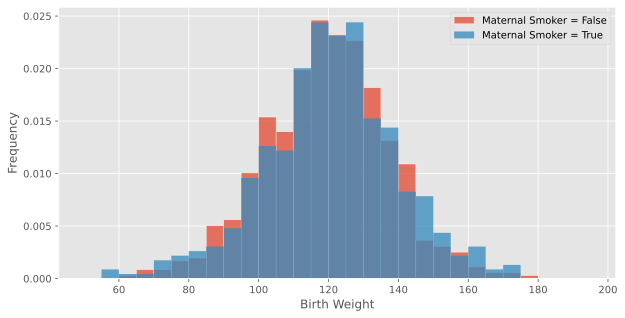

In [44]:
fig, ax = plt.subplots()
smokers = babies_with_shuffled[babies_with_shuffled.get('Shuffled_Labels')]
non_smokers = babies_with_shuffled[babies_with_shuffled.get('Shuffled_Labels') == False]
non_smokers.plot(kind='hist', y='Birth Weight', density=True, ax=ax, alpha=0.75, bins=baby_bins, ec='w', figsize=(10, 5))
smokers.plot(kind='hist',y='Birth Weight', density=True, ax=ax, alpha=0.75, bins=baby_bins)
plt.legend(['Maternal Smoker = False', 'Maternal Smoker = True'])
plt.xlabel('Birth Weight');

What do you notice? 👀

### How close are the means of the shuffled groups?

In [45]:
babies_with_shuffled.groupby('Shuffled_Labels').mean().get(['Birth Weight'])

,Birth Weight
Shuffled_Labels,
False,118.94
True,120.28


In [46]:
group_means = babies_with_shuffled.groupby('Shuffled_Labels').mean().get('Birth Weight')
group_means.loc[False] - group_means.loc[True]

-1.3439828145710493

This is the test statistic for one experiment (one "shuffle"). Let's write a function that can compute this test statistic for any shuffle.

In [47]:
def difference_in_group_means(weights_df):
    group_means = weights_df.groupby('Shuffled_Labels').mean().get('Birth Weight')
    return group_means.loc[False] - group_means.loc[True]

difference_in_group_means(babies_with_shuffled)

-1.3439828145710493

### Simulation

- This was just one random shuffle.

- How likely is it that a random shuffle results in a 9.26+ ounce difference in means?

- We have to repeat the shuffling a bunch of times. On each iteration:
    1. Shuffle the labels.
    2. Put them in a DataFrame.
    3. Call `difference_in_group_means`.

### Running the simulation

In [48]:
n_repetitions = 500 # The dataset is large, so it takes too long to run if we use 5000 or 10000
differences = np.array([])

for i in np.arange(n_repetitions):
    # Step 1: Shuffle the labels
    shuffled_labels = np.random.permutation(babies.get('Maternal Smoker'))
    
    # Step 2: Put them in a DataFrame
    shuffled = babies_with_shuffled.assign(Shuffled_Labels=shuffled_labels)
    
    # Step 3: Compute the difference in group means and add the result to the differences array
    difference = difference_in_group_means(shuffled)
    
    differences = np.append(differences, difference)
    
differences

array([-0.16,  1.05, -2.83, ...,  0.22,  1.88, -0.41])

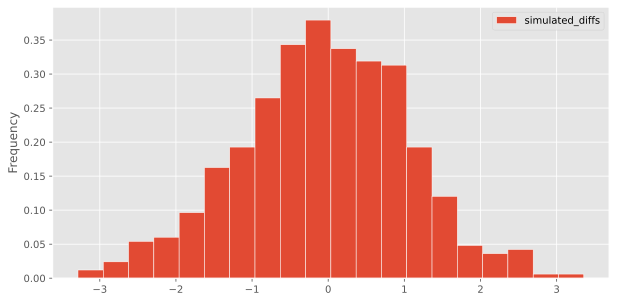

In [49]:
(bpd.DataFrame()
 .assign(simulated_diffs=differences)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);

- Note that the empirical distribution of the test statistic (difference in means) is centered around 0.
- This matches our intuition – if the null hypothesis is true, there should be no difference in the group means on average.

### Conclusion of the test

Where does our observed statistic lie?

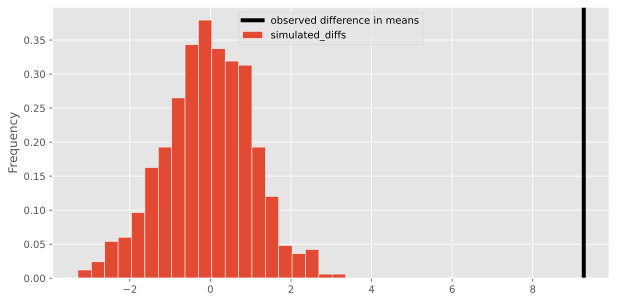

In [50]:
(bpd.DataFrame()
 .assign(simulated_diffs=differences)
 .plot(kind='hist', bins=20, density=True, ec='w', figsize=(10, 5))
);
plt.axvline(observed_difference, color='black', linewidth=4, label='observed difference in means')
plt.legend();

In [51]:
smoker_p_value = np.count_nonzero(differences >= observed_difference) / n_repetitions
smoker_p_value

0.0

### Conclusion

- Under the null hypothesis, we rarely see differences as large as 9.26 ounces.

- Therefore, we reject the null hypothesis: the evidence implies that the groups do not come from the same distribution.

- <details><summary>Can we conclude that smoking <i>causes</i> lower birth weight? Why or why not? Think about it, then click here for the answer.</summary>No, we cannot. This was an observational study; there may be confounding factors. For instance, maybe smokers are more likely to drink caffeine, and caffeine causes lower birth weight.
</details>

In [52]:
show_permutation_testing_summary()

### Concept Check ✅ – Answer at [cc.dsc10.com](http://cc.dsc10.com)

Recall, `babies` has two columns.

In [ ]:
babies.take(np.arange(3))

To randomly assign weights to groups, we shuffled `'Maternal Smoker'` column. Could we have shuffled the `'Birth Weight'` column instead?

- A. Yes
- B. No

<details>
    <summary>Click here to see the answer to the previous question <b>after</b> you've submitted an answer to it.</summary>
    
<b>Yes</b>, we could have. It doesn’t matter which column we shuffle – we could shuffle one or the other, or even both, as long as we shuffle each separately. 
    
Think about it like this – pretend you bring a gift 🎁 to a Christmas party 🎄 for a gift exchange, where everyone must leave the party with a random person’s gift. Pretend everyone stands around a circular table and puts the gift they bought in front of them. To randomly assign people to gifts, you could shuffle the gifts on the table and have all the people stay in the same spot, or you could have the people physically shuffle and keep the gifts in the same spots, or you could do both – either way, everyone will end up with a random gift!
    
</details>

## Summary, next time

### Summary

- The total variation distance is a test statistic that measures the difference between two categorical distributions.
    - Note: the TVD is not used for permutation tests!
- Before today, we used hypothesis tests to determine if **one sample** came from a known population distribution.
- Permutation tests help us determine if **two samples** came from the same population. We can answers questions like:
    - "Do smokers' babies and non-smokers babies' weigh the same?"
    - More generally: are these things like those things?

### A/B testing

- Permutation tests are one way to perform A/B tests.
- These are both also hypothesis tests.
- An A/B test aims to determine if two samples are from the same population (the name comes from giving names to the samples – sample A and sample B).
- We implemented A/B tests by using permutations. Butside of this class, permutation tests can be used for other purposes, and A/B tests can be done without permutations.
- **For us, they mean the same thing, so if you see A/B test anywhere in the class, it refers to a permutation test.**

### Next time

- Another example of a permutation test. 🏈
- Bootstrapping – a technique that will allow us to draw random samples from a population, when all we have access to is a single sample!